In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

plt.rcParams["figure.figsize"] = (15, 15)

%matplotlib inline

# Modeling the random walk  

We assume the following:

1) X and Y are independent

2) Each jump of the fire over given timestep t

Our approach is to treat the spread of fire as a random walk on $x$ and $y$.
For each step of the random walk, we'll treat the velocity as a random variable from a distribution $N(\mu, \sigma^2)$

Our input data is a set of trajectories based off of the given tweets. 
Each trajectory gives us a set of jumps associated with the given fire of interest in our region. 


In [0]:
numtweets = 30
r = 50
variance = 5
binsize = 4

#x, y, and timestamp of each tweet
testx = np.linspace(0, r, numtweets) + np.random.normal(0,variance,numtweets)
testy = np.linspace(0, r, numtweets) + np.random.normal(0,variance,numtweets)
testt = np.arange(testx.shape[0])


bins = np.arange(min(testt), max(testt), binsize) #make some bins based on binsize
inds = np.digitize(testt, bins) #for each time in testt, assign it to a bin; 
#the bin of element i in testt will be the bin for element i in testx and testy also
 
numbins = len(bins)

x_trajectories = [] 
y_trajectories = [] 

for i in range(numbins):
    tempx = []
    tempy = []
    for j in range(len(testt)):
        if inds[j] == i + 1: #since bin 0 is indexed as 1
            tempx += [testx[j]] #if the jth element of testt is in bin i, 
            tempy += [testy[j]] #add testx[j] and testy[j] to their appropriate bins
    x_trajectories += [tempx]
    y_trajectories += [tempy]

    
combinatorial_x_trajectories = list(itertools.product(*x_trajectories))
combinatorial_y_trajectories = list(itertools.product(*y_trajectories))

x_distances = [np.diff(i) for i in combinatorial_x_trajectories]
y_distances = [np.diff(i) for i in combinatorial_y_trajectories]

x_distances = np.reshape(x_distances, -1)
y_distances = np.reshape(y_distances, -1)

vx = x_distances/binsize
vy = y_distances/binsize

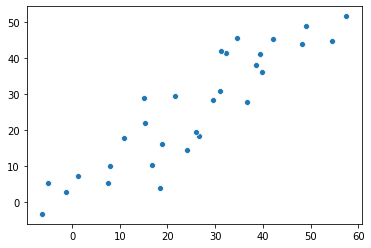

In [0]:
sns.scatterplot(testx, testy);

In [0]:
def MLE_mu(data):
    n = len(data)
    return 1/n * np.sum(data)

def MLE_sigma2(data):
    n = len(data)
    mu_hat = MLE_mu(data)
    return 1/n * np.sum((data - mu_hat)**2)


Since the behavior of fire spread is uncertain, we assume each trajectory represents an equally likely path of the the fire.
Based off of this, each link $A\to B$ gives us a "representative" sample of the underlying distribution  of velocities, both of x and y.

Therefore, the approach will to be to calculate the $v_x = d_x/t$ for each link of Tweets per trajectory, then to use these to calculate MLEs for the normal distribution governing the velocities of each hop. 

Once we have the normal distribution for these hops, we can use this to predict the probability that the fire has reached some point $A$ by some time $T$.
There are two ways we can do this:

1) Set some timestep $t$ within the range of timesteps that we have seen in the data, and subdivide the desired segment into even chunks such that $\sum t_i = T$ and then add the normals such that the add up to the correct value. 
In this case, say we have $n$ chunks, 
Then, the probability that a fire has spread to at least to point $A$ is 
$$
\begin{align}
P\left(\sum_{i=1}^n x_i \geq A \right) &= P\left(\sum_{i=1}^n tv_i \geq A \right) \\
&= P\left(\sum_{i=1}^n v_i \geq \frac{A}{t} \right)\\
&= P\left(N(n\mu, n\sigma^2)\geq \frac{A}{t} \right)\\
&= P\left(N(n\mu, n\sigma^2)\geq \frac{A}{T/n} \right)\\
&= P\left(N(n\mu, n\sigma^2)\geq \frac{nA}{T} \right)\\
&= P\left(N(\mu, \sigma^2)\geq \frac{A}{T} \right)
\end{align}
$$

2) Find the average velocity required to traverse the whole path in one go and find that probability.
$$
\begin{align}
P(X \geq A) &= P\left(vT \geq A\right)\\
&= P\left(v \geq \frac{A}{T}\right)\\
&= P\left(N(\mu, \sigma^2) \geq \frac{A}{T}\right)\\
\end{align}
$$

Let's apply these ideas below.


First, calculate velocity components based off of the given data:

In [0]:
# vx, vy

(array([ 2.52310822, -1.6544361 ,  1.58150142, ...,  3.94943556,
         0.20712346,  2.1478424 ]),
 array([ 3.51277876,  3.83798799, -0.82903521, ...,  3.69953839,
         1.46260731,  0.83939873]))

In [0]:
# timesteps = np.diff(testt)
# vx = np.diff(testx)/timesteps
# vy = np.diff(testy)/timesteps

Get MLE estimates for $v_x$, $v_y$

In [0]:
muhat_y, sigmahat_y = MLE_mu(vy), MLE_sigma2(vy)
muhat_x, sigmahat_x = MLE_mu(vx), MLE_sigma2(vx)
print("means, x and y: " , muhat_x, muhat_y)
print("variances, x and y: ", sigmahat_x, sigmahat_y)

means, x and y:  1.8084442148956452 1.670938735439651
variances, x and y:  3.3483606084057564 2.7596994513903934


In [0]:
vy_dist = norm(loc = muhat_y,  scale = np.sqrt(sigmahat_y))
vx_dist = norm(loc = muhat_x, scale = np.sqrt(sigmahat_x))

In [0]:
predictx = [vx_dist.mean() * t for t in testt]

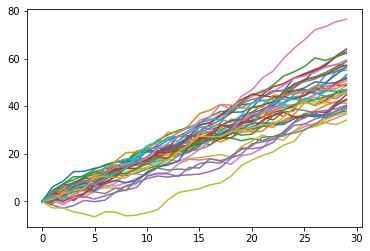

In [0]:
simulated_y_trajectories = []
for i in range(40):
    simulated_position = [0]
    last = 0

    for t in testt[1:]:
        last += vy_dist.rvs()
        simulated_position += [last]
    
    plt.plot(testt, simulated_position)
    simulated_y_trajectories += [simulated_position]

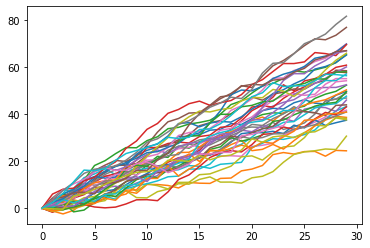

In [0]:
simulated_x_trajectories = []
for i in range(40):
    simulated_position = [0]
    last = 0

    for t in testt[1:]:
        last += vx_dist.rvs()
        simulated_position += [last]
    
    plt.plot(testt, simulated_position)
    simulated_x_trajectories += [simulated_position]

In [0]:
import seaborn as sns
simulated_x_trajectories_plot = np.reshape(simulated_x_trajectories, -1)
simulated_y_trajectories_plot = np.reshape(simulated_y_trajectories, -1)

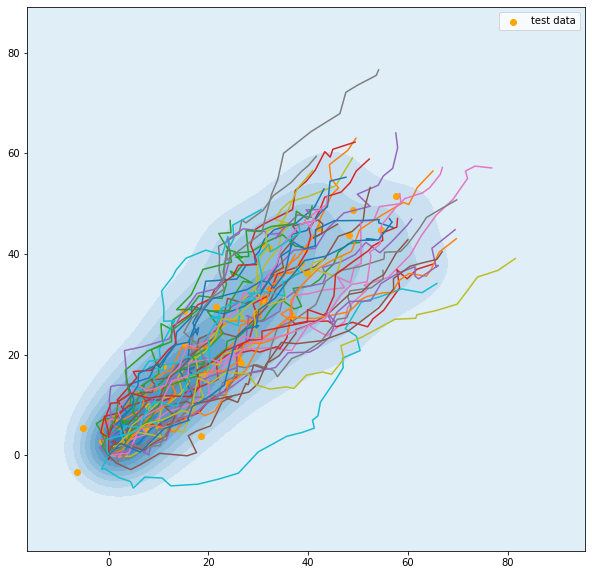

In [0]:
plt.figure(figsize = (10, 10))
sns.kdeplot(simulated_x_trajectories_plot, simulated_y_trajectories_plot, shade = True)
for x_traj, y_traj in zip(simulated_x_trajectories, simulated_y_trajectories):
    plt.plot(x_traj, y_traj)
plt.scatter(testx, testy, label = "test data", color = 'orange')
plt.legend();

In [0]:
 def rw_simulation(tweetinputlist, numbins = 5, plotstep = .1, minlat = None, maxlat = None, minlong = None , matlong = None):
  """
  Take in a 2D list, where each element has
  Latitude at index 0
  Longitude at index 1
  Time of tweet at index 2

  Also takes in the number of buckets that the time has been discretized into

  Latitude is y, longitude is x

  plotstep determines the mesh size for which we plot

  Returns:
  2D list, where each element is 
  Latitude at index 0
  Longitude at index 1
  Weight on (0,1) at index 2
  """
  ###############
  ### imports ###
  ###############

  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.stats import norm
  import itertools
  import seaborn as sns

  ######################
  ### Helper methods ###
  ######################

  def MLE_mu(data):
      n = len(data)
      return 1/n * np.sum(data)

  def MLE_sigma2(data):
      n = len(data)
      mu_hat = MLE_mu(data)
      return 1/n * np.sum((data - mu_hat)**2)

  #################
  ### Main body ###
  #################

  #unpack the input
  testt = [i[2] for i in tweetinputlist]
  testx = [i[0] for i in tweetinputlist]
  testy = [i[1] for i in tweetinputlist]
      
  numtweets = 30
  r = 50
  variance = 5
  binsize = 4

  #x, y, and timestamp of each tweet
  testx = np.linspace(0, r, numtweets) + np.random.normal(0,variance,numtweets)
  testy = np.linspace(0, r, numtweets) + np.random.normal(0,variance,numtweets)
  testt = np.arange(testx.shape[0])


  bins = np.arange(min(testt), max(testt), binsize) #make some bins based on binsize
  inds = np.digitize(testt, bins) #for each time in testt, assign it to a bin; 
  #the bin of element i in testt will be the bin for element i in testx and testy also
  
  numbins = len(bins)

  x_trajectories = [] 
  y_trajectories = [] 

  for i in range(numbins):
      tempx = []
      tempy = []
      for j in range(len(testt)):
          if inds[j] == i + 1: #since bin 0 is indexed as 1
              tempx += [testx[j]] #if the jth element of testt is in bin i, 
              tempy += [testy[j]] #add testx[j] and testy[j] to their appropriate bins
      x_trajectories += [tempx]
      y_trajectories += [tempy]

      
  combinatorial_x_trajectories = list(itertools.product(*x_trajectories))
  combinatorial_y_trajectories = list(itertools.product(*y_trajectories))

  x_distances = [np.diff(i) for i in combinatorial_x_trajectories]
  y_distances = [np.diff(i) for i in combinatorial_y_trajectories]

  x_distances = np.reshape(x_distances, -1)
  y_distances = np.reshape(y_distances, -1)

  vx = x_distances/binsize
  vy = y_distances/binsize

  muhat_y, sigmahat_y = MLE_mu(vy), MLE_sigma2(vy)
  muhat_x, sigmahat_x = MLE_mu(vx), MLE_sigma2(vx)

  vy_dist = norm(loc = muhat_y,  scale = np.sqrt(sigmahat_y))
  vx_dist = norm(loc = muhat_x, scale = np.sqrt(sigmahat_x))

  simulated_y_trajectories = []
  for i in range(40):
      simulated_position = [0]
      last = 0

      for t in testt[1:]:
          last += vy_dist.rvs()
          simulated_position += [last]
      
      simulated_y_trajectories += [simulated_position]

  simulated_x_trajectories = []
  for i in range(40):
      simulated_position = [0]
      last = 0

      for t in testt[1:]:
          last += vx_dist.rvs()
          simulated_position += [last]
      
      simulated_x_trajectories += [simulated_position]

  simulated_x_trajectories_plot = np.reshape(simulated_x_trajectories, -1)
  simulated_y_trajectories_plot = np.reshape(simulated_y_trajectories, -1)

  #################
  ### Viz block ###
  #################

  # plt.figure(figsize = (10, 10))
  # sns.kdeplot(simulated_x_trajectories_plot, simulated_y_trajectories_plot, shade = True)
  # for x_traj, y_traj in zip(simulated_x_trajectories, simulated_y_trajectories):
  #     plt.plot(x_traj, y_traj)
  # plt.scatter(testx, testy, label = "test data", color = 'orange')
  # plt.legend();

  import numpy as np
  import scipy.stats as stats
  from matplotlib.pyplot import imshow

  rvs = np.append(np.array([simulated_x_trajectories_plot]),
                  np.array([simulated_y_trajectories_plot]),
                  axis=1).reshape(-1, 2)

  kde = stats.kde.gaussian_kde(rvs.T)

  # Regular grid to evaluate kde upon
  kde = stats.kde.gaussian_kde(rvs.T)

  # Regular grid to evaluate kde upon
  if minlat == None:
    x_flat = np.arange(rvs[:, 0].min(), rvs[:,0].max(), plotstep)
    y_flat = np.arange(rvs[:, 1].min(), rvs[:,1].max(), plotstep)
  else:
    x_flat = np.arange(minlong, maxlong, .1)
    y_flat = np.arange(minlat, maxlat, .1)

  x,y = np.meshgrid(x_flat,y_flat)
  grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)

  z = np.array(kde(grid_coords.T))
  
  return np.array([[x, y, z] for x, y, z in zip(grid_coords[:,0], grid_coords[:,1], z)])


  


In [0]:
simtweets = [list(i) for i in zip(testx, testy, testt)]

In [0]:
plotpoints = rw_simulation(simtweets, 5, 1)

In [0]:
x, y, z = plotpoints[:, 0], plotpoints[:, 1], plotpoints[:, 2]

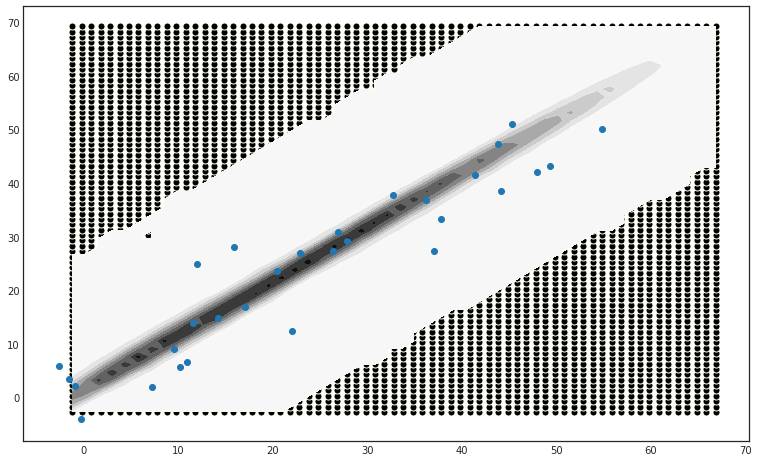

In [0]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline


def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z



X,Y,Z = plot_contour(x,y,z,resolution = 50,contour_method='linear')

with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(13,8))
    ax.scatter(x,y, color="black", linewidth=1, edgecolor="ivory", s=50)
    ax.contourf(X,Y,Z)
ax.scatter(testx, testy);

# What happens with multiple fires?

Inclusion exclusion:
$$
\begin{align}
P(fire @  A @  t) &= P(fire 1 @  A @  t) + P(fire 2 @  A @  t) - P(fire 1 \cap fire 2 @  A @  t)\\
&= P(fire 1 @  A @  t) + P(fire 2 @  A @  t) - P(fire 1 @  A @  t)P(fire 1 @  A @  t)
\end{align}
$$
for time $t$ and point of interest $A$